# Transfer Learning - DenseNet

In [9]:
import os
import glob
import pathlib
from tqdm import tqdm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.models import Sequential, load_model
from keras.utils import np_utils
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import shap

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [2]:
img_dim = 128
num_classes = 15
batch_size = 128
epochs = 5

In [3]:
# data augmentation
trainGen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

valGen = ImageDataGenerator(
    rescale=1./255)

testGen = ImageDataGenerator(
    rescale=1./255)

train_generator = trainGen.flow_from_directory(
        'data/training',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
validation_generator = valGen.flow_from_directory(
        'data/validation',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
test_generator = testGen.flow_from_directory(
        'data/testing',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 60662 images belonging to 15 classes.
Found 6780 images belonging to 15 classes.
Found 16789 images belonging to 15 classes.


In [4]:
category_name = {'111': 'Bag', '137': 'Sandals', '155': 'Jeans', '160': 'Sweater', '228': 'Skirt', '284': 'Shoes', '33': 'Cardigan',\
                 '368': 'Dress', '42': 'Blouse', '461': 'Pants', '48': 'Boots', '50': 'Coat', '505': 'Shirt', '516': 'Tights', '52': 'T-Shirt'}
class_names = [category_name[k] for k in train_generator.class_indices.keys()]

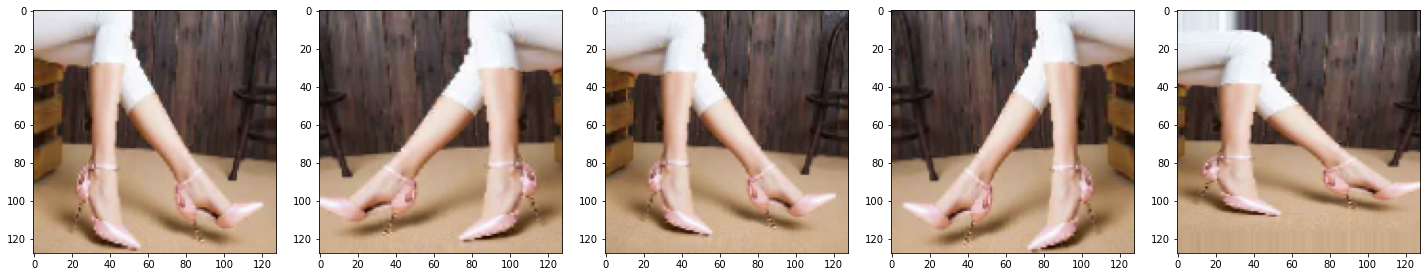

In [5]:
# plot data augmentation
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [7]:
densenet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [8]:
densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [9]:
densenet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [10]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [11]:
densenet201.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Model 1

In [12]:
for layer in densenet121.layers:
    layer.trainable = False

In [13]:
model = Sequential()
model.add(densenet121)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1024)        4096      
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

In [14]:
checkpoint = ModelCheckpoint(
    filepath='densenet121_model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [15]:
history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.6492 - accuracy: 0.4802
Epoch 00001: val_accuracy improved from -inf to 0.57198, saving model to densenet121_model.h5
474/474 [==============================] - 500s 1s/step - loss: 1.6492 - accuracy: 0.4802 - val_loss: 1.2766 - val_accuracy: 0.5720
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 1.3170 - accuracy: 0.5510
Epoch 00002: val_accuracy improved from 0.57198 to 0.60221, saving model to densenet121_model.h5
474/474 [==============================] - 221s 466ms/step - loss: 1.3170 - accuracy: 0.5510 - val_loss: 1.1524 - val_accuracy: 0.6022
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 1.2589 - accuracy: 0.5697
Epoch 00003: val_accuracy improved from 0.60221 to 0.60973, saving model to densenet121_model.h5
474/474 [==============================] - 222s 468ms/step - loss: 1.2589 - accuracy: 0.5697 - val_loss: 1.1341 - val_accuracy: 0.6097
Epoch 4/5
474/474 [======

In [16]:
model = load_model('densenet121_model.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 80s 603ms/step - loss: 1.1331 - accuracy: 0.6098


0.6098040342330933

<Figure size 2160x720 with 0 Axes>

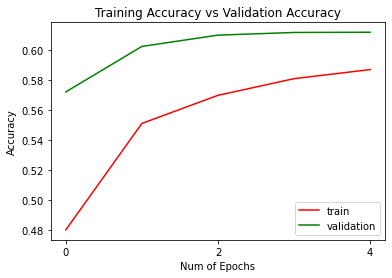

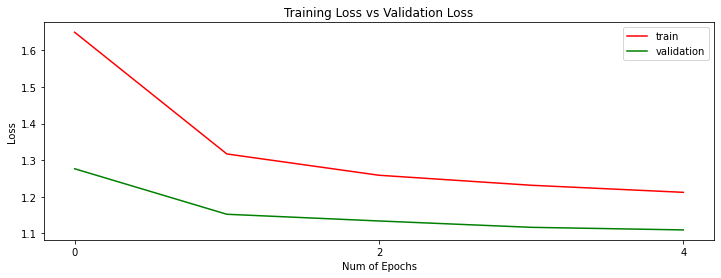

In [17]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

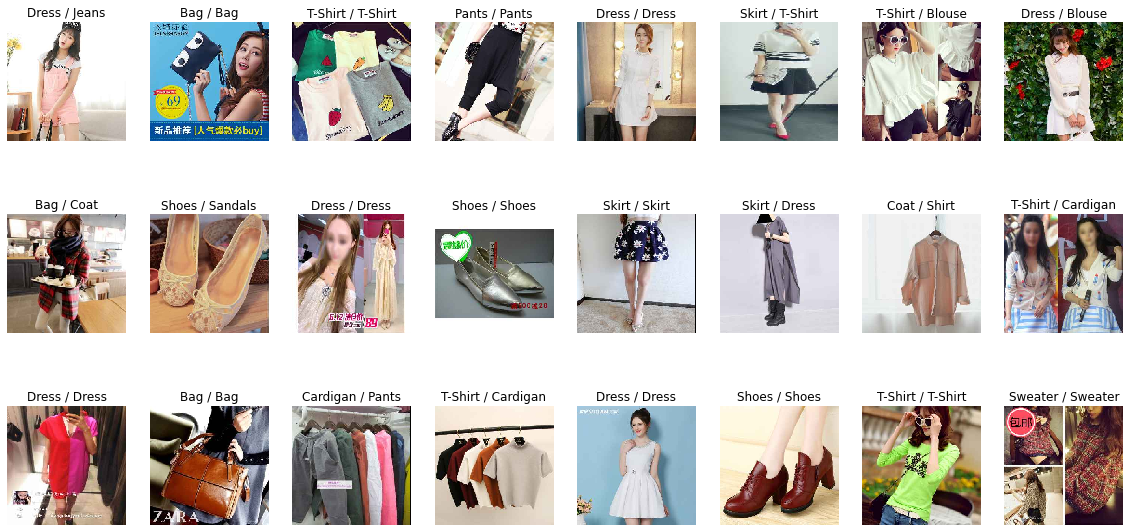

In [18]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 2

In [19]:
for layer in densenet169.layers:
    layer.trainable = False

In [20]:
model = Sequential()
model.add(densenet169)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 4, 4, 1664)        12642880  
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 1664)        6656      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 1664)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1664)              6656      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               426240    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

In [21]:
checkpoint = ModelCheckpoint(
    'densenet169_model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [22]:
history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.5015
Epoch 00001: val_accuracy improved from -inf to 0.58614, saving model to densenet169_model.h5
474/474 [==============================] - 234s 493ms/step - loss: 1.5671 - accuracy: 0.5015 - val_loss: 1.2238 - val_accuracy: 0.5861
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 1.2566 - accuracy: 0.5739
Epoch 00002: val_accuracy improved from 0.58614 to 0.61460, saving model to densenet169_model.h5
474/474 [==============================] - 230s 485ms/step - loss: 1.2566 - accuracy: 0.5739 - val_loss: 1.1137 - val_accuracy: 0.6146
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 1.2006 - accuracy: 0.5920
Epoch 00003: val_accuracy improved from 0.61460 to 0.61755, saving model to densenet169_model.h5
474/474 [==============================] - 234s 494ms/step - loss: 1.2006 - accuracy: 0.5920 - val_loss: 1.1058 - val_accuracy: 0.6176
Epoch 4/5
474/474 [===

In [23]:
model = load_model('densenet169_model.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 19s 142ms/step - loss: 1.0860 - accuracy: 0.6274


0.6274346113204956

<Figure size 2160x720 with 0 Axes>

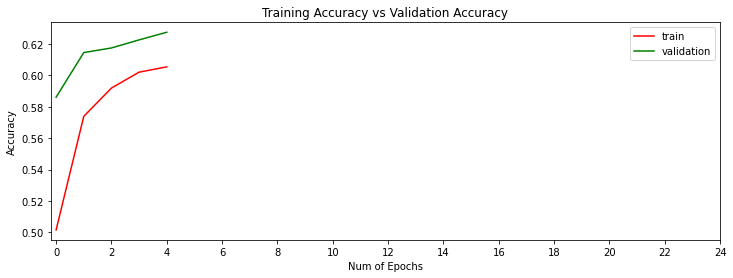

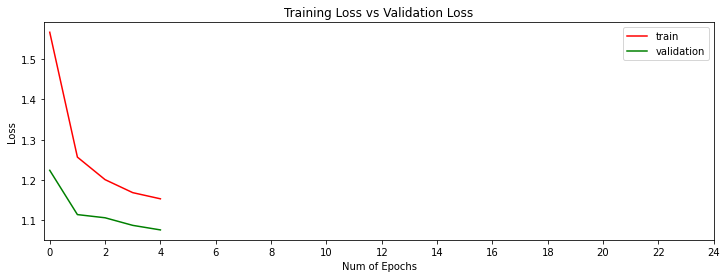

In [24]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 26, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 26, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

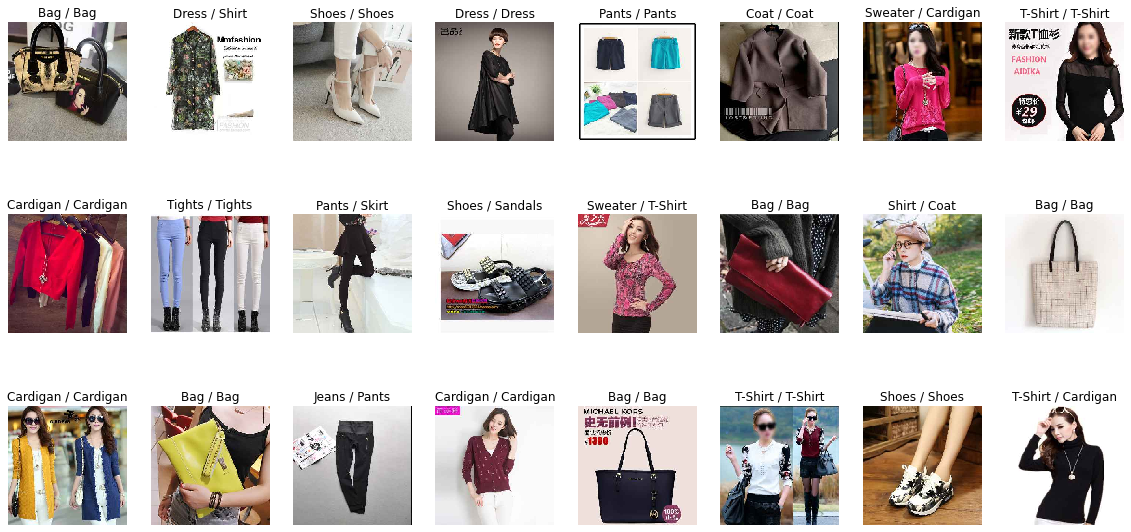

In [25]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 3

In [26]:
for layer in densenet201.layers:
    layer.trainable = False

In [27]:
model = Sequential()
model.add(densenet201)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 1920)        7680      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               491776    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)              

In [28]:
checkpoint = ModelCheckpoint(
    'densenet201_model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [29]:
history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.5503 - accuracy: 0.5053
Epoch 00001: val_accuracy improved from -inf to 0.58997, saving model to densenet201_model.h5
474/474 [==============================] - 244s 514ms/step - loss: 1.5503 - accuracy: 0.5053 - val_loss: 1.2158 - val_accuracy: 0.5900
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.5774
Epoch 00002: val_accuracy improved from 0.58997 to 0.61180, saving model to densenet201_model.h5
474/474 [==============================] - 233s 491ms/step - loss: 1.2418 - accuracy: 0.5774 - val_loss: 1.1149 - val_accuracy: 0.6118
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 1.1829 - accuracy: 0.5970
Epoch 00003: val_accuracy improved from 0.61180 to 0.61888, saving model to densenet201_model.h5
474/474 [==============================] - 269s 569ms/step - loss: 1.1829 - accuracy: 0.5970 - val_loss: 1.0957 - val_accuracy: 0.6189
Epoch 4/5
474/474 [===

In [31]:
model = load_model('densenet201_model.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 27s 208ms/step - loss: 1.0786 - accuracy: 0.6282


0.6282089352607727

<Figure size 2160x720 with 0 Axes>

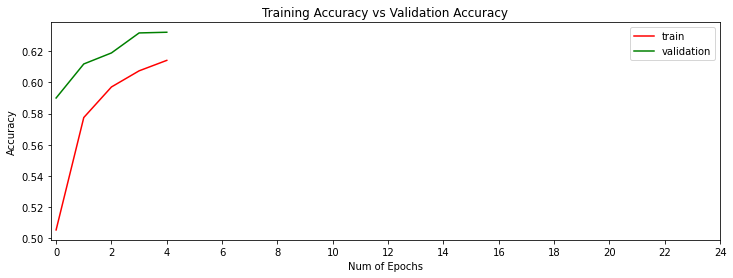

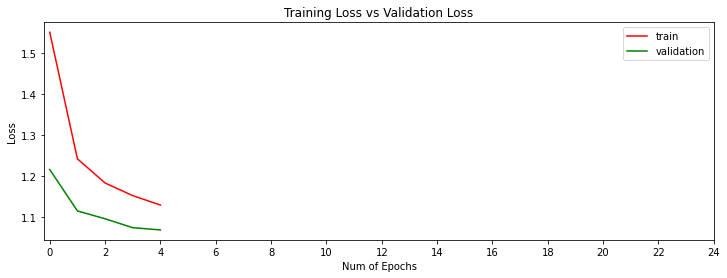

In [32]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 26, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 26, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

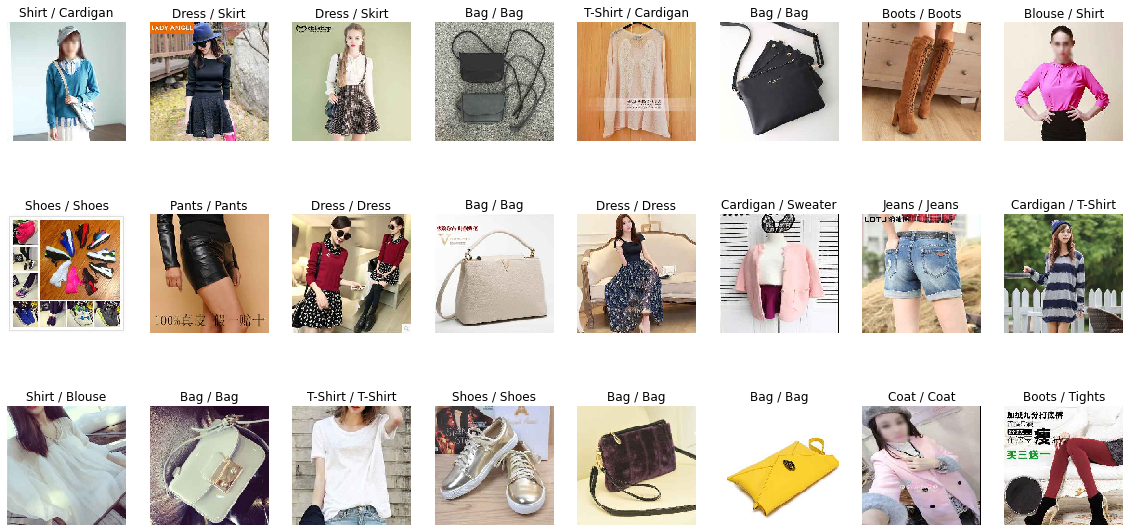

In [33]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 4

In [41]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [42]:
i = 0
for layer in densenet201.layers:
    i += 1
i

707

In [43]:
for layer in densenet201.layers[:600]:
    layer.trainable = False

In [44]:
for l in densenet201.layers:
    print(l.name, l.trainable)

input_5 False
zero_padding2d_8 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_9 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_co

In [45]:
model = Sequential()
model.add(densenet201)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 4, 1920)        7680      
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 1920)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               491776    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)              

In [46]:
checkpoint = ModelCheckpoint(
    'densenet201_model_2.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [47]:
history = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.3753 - accuracy: 0.5578
Epoch 00001: val_accuracy improved from -inf to 0.64100, saving model to densenet201_model_2.h5
474/474 [==============================] - 236s 498ms/step - loss: 1.3753 - accuracy: 0.5578 - val_loss: 1.0341 - val_accuracy: 0.6410
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.6459
Epoch 00002: val_accuracy improved from 0.64100 to 0.66578, saving model to densenet201_model_2.h5
474/474 [==============================] - 241s 509ms/step - loss: 1.0379 - accuracy: 0.6459 - val_loss: 0.9643 - val_accuracy: 0.6658
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.6770
Epoch 00003: val_accuracy did not improve from 0.66578
474/474 [==============================] - 275s 581ms/step - loss: 0.9456 - accuracy: 0.6770 - val_loss: 0.9908 - val_accuracy: 0.6634
Epoch 4/5
474/474 [==============================] - ETA: 0s

In [48]:
model = load_model('densenet201_model_2.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 22s 166ms/step - loss: 0.9732 - accuracy: 0.6740


0.6739531755447388

<Figure size 2160x720 with 0 Axes>

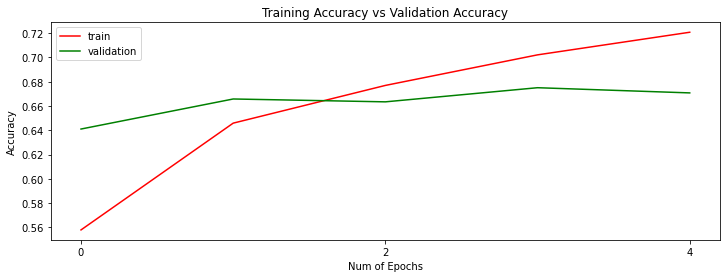

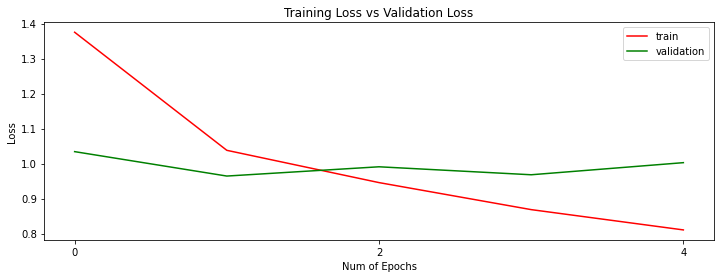

In [49]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

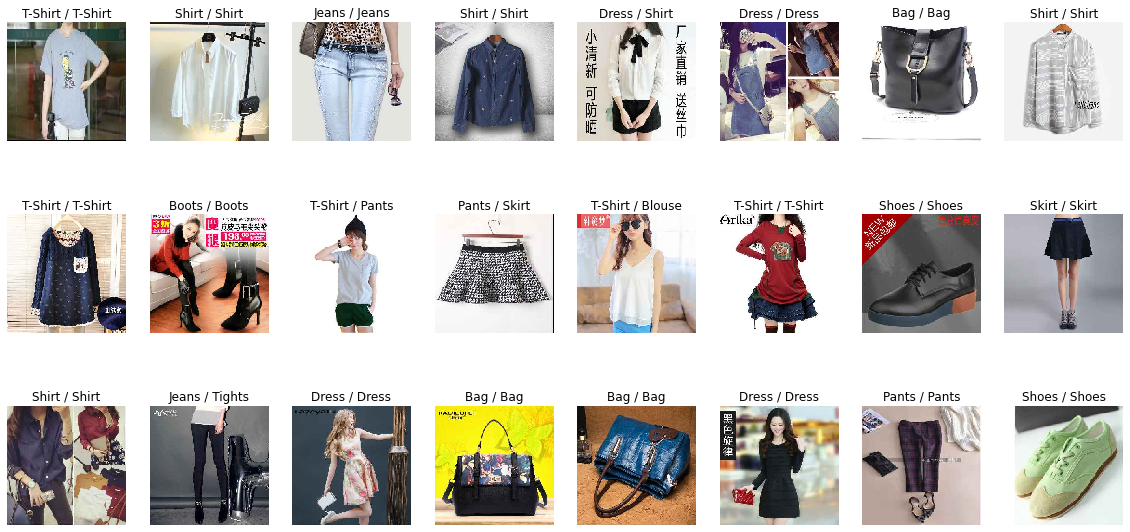

In [50]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 5

In [51]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [52]:
for layer in densenet201.layers[:500]:
    layer.trainable = False

In [53]:
for l in densenet201.layers:
    print(l.name, l.trainable)

input_6 False
zero_padding2d_10 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_11 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

In [54]:
model = Sequential()
model.add(densenet201)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization_15 (Batc (None, 4, 4, 1920)        7680      
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 1920)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               491776    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)              

In [55]:
checkpoint = ModelCheckpoint(
    'densenet201_model_3.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [56]:
history = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.3013 - accuracy: 0.5762
Epoch 00001: val_accuracy improved from -inf to 0.64351, saving model to densenet201_model_3.h5
474/474 [==============================] - 253s 533ms/step - loss: 1.3013 - accuracy: 0.5762 - val_loss: 1.0351 - val_accuracy: 0.6435
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.6548
Epoch 00002: val_accuracy improved from 0.64351 to 0.66917, saving model to densenet201_model_3.h5
474/474 [==============================] - 275s 579ms/step - loss: 1.0110 - accuracy: 0.6548 - val_loss: 0.9658 - val_accuracy: 0.6692
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.6835
Epoch 00003: val_accuracy did not improve from 0.66917
474/474 [==============================] - 327s 690ms/step - loss: 0.9263 - accuracy: 0.6835 - val_loss: 1.2111 - val_accuracy: 0.6642
Epoch 4/5
474/474 [==============================] - ETA: 0s

In [57]:
model = load_model('densenet201_model_3.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 92s 697ms/step - loss: 0.9444 - accuracy: 0.6812


0.6812198758125305

<Figure size 2160x720 with 0 Axes>

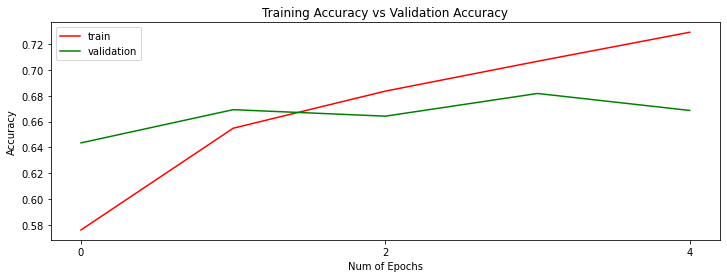

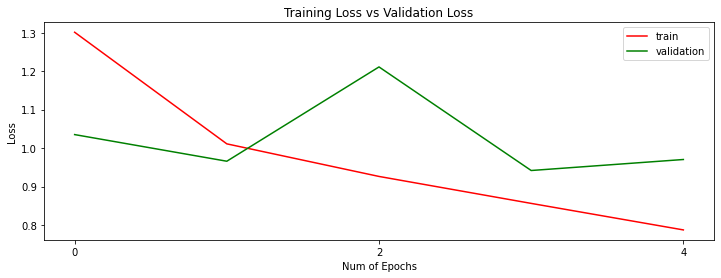

In [58]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

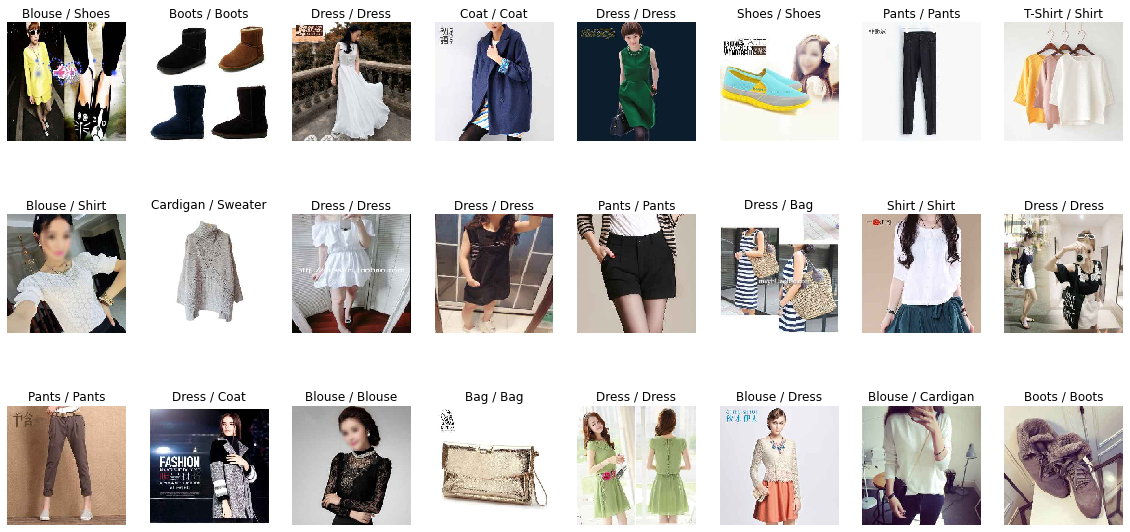

In [59]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 6

In [60]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [61]:
for layer in densenet201.layers[:400]:
    layer.trainable = False

In [62]:
for l in densenet201.layers:
    print(l.name, l.trainable)

input_7 False
zero_padding2d_12 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_13 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

In [63]:
model = Sequential()
model.add(densenet201)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 4, 1920)        7680      
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 1920)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               491776    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)              

In [64]:
checkpoint = ModelCheckpoint(
    'densenet201_model_4.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [65]:
history = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.2548 - accuracy: 0.5937
Epoch 00001: val_accuracy improved from -inf to 0.65354, saving model to densenet201_model_4.h5
474/474 [==============================] - 255s 538ms/step - loss: 1.2548 - accuracy: 0.5937 - val_loss: 0.9975 - val_accuracy: 0.6535
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.6881
Epoch 00002: val_accuracy improved from 0.65354 to 0.67788, saving model to densenet201_model_4.h5
474/474 [==============================] - 263s 556ms/step - loss: 0.9299 - accuracy: 0.6881 - val_loss: 3.1022 - val_accuracy: 0.6779
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.7155
Epoch 00003: val_accuracy did not improve from 0.67788
474/474 [==============================] - 270s 569ms/step - loss: 0.8407 - accuracy: 0.7155 - val_loss: 0.9809 - val_accuracy: 0.6737
Epoch 4/5
474/474 [==============================] - ETA: 0s

In [66]:
model = load_model('densenet201_model_4.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 96s 727ms/step - loss: 0.9013 - accuracy: 0.7067


0.7066531777381897

<Figure size 2160x720 with 0 Axes>

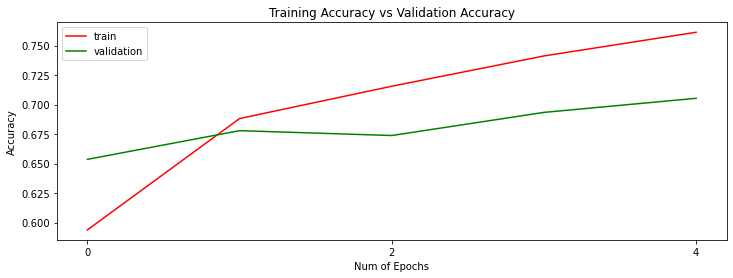

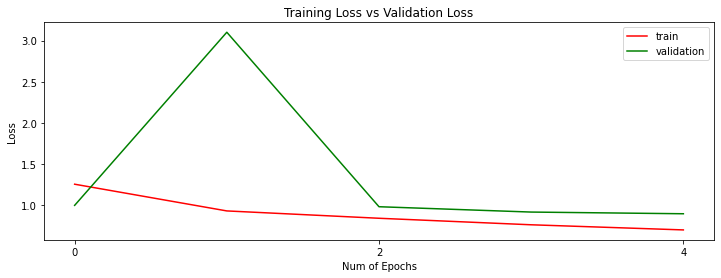

In [67]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

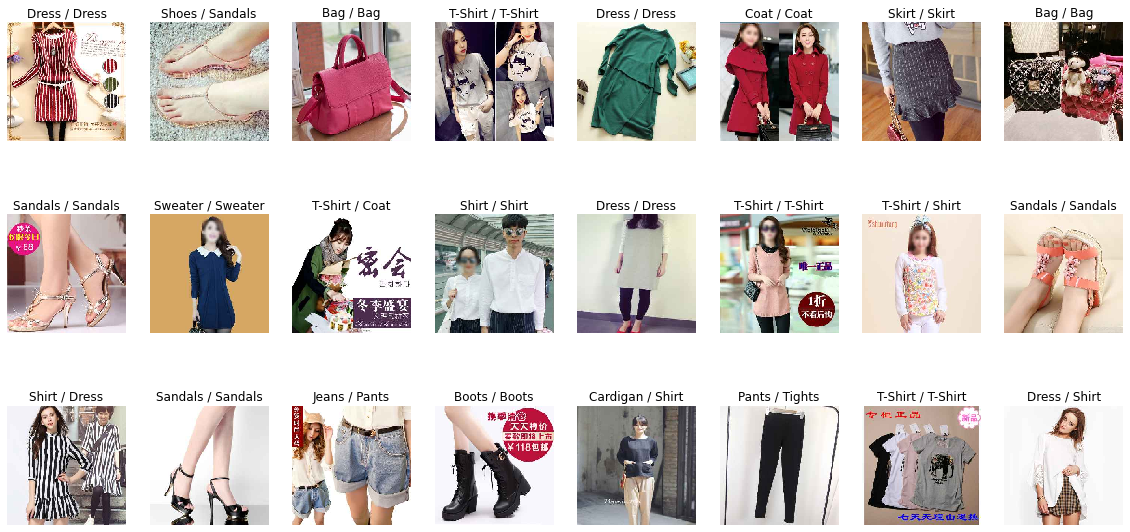

In [68]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 7

In [69]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

In [70]:
for layer in densenet201.layers[:350]:
    layer.trainable = False

In [71]:
for l in densenet201.layers:
    print(l.name, l.trainable)

input_8 False
zero_padding2d_14 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_15 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

In [72]:
model = Sequential()
model.add(densenet201)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization_21 (Batc (None, 4, 4, 1920)        7680      
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 4, 1920)        0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               491776    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)              

In [73]:
checkpoint = ModelCheckpoint(
    'densenet201_model_5.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [74]:
history = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/5
474/474 [==============================] - ETA: 0s - loss: 1.2295 - accuracy: 0.5981
Epoch 00001: val_accuracy improved from -inf to 0.63024, saving model to densenet201_model_5.h5
474/474 [==============================] - 612s 1s/step - loss: 1.2295 - accuracy: 0.5981 - val_loss: 1.1312 - val_accuracy: 0.6302
Epoch 2/5
474/474 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.6857
Epoch 00002: val_accuracy improved from 0.63024 to 0.68555, saving model to densenet201_model_5.h5
474/474 [==============================] - 394s 831ms/step - loss: 0.9336 - accuracy: 0.6857 - val_loss: 0.9512 - val_accuracy: 0.6855
Epoch 3/5
474/474 [==============================] - ETA: 0s - loss: 0.8548 - accuracy: 0.7118
Epoch 00003: val_accuracy improved from 0.68555 to 0.69912, saving model to densenet201_model_5.h5
474/474 [==============================] - 335s 708ms/step - loss: 0.8548 - accuracy: 0.7118 - val_loss: 0.8911 - val_accuracy: 0.6991
Epoch 4/5
474/474 [

In [75]:
model = load_model('densenet201_model_5.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 100s 761ms/step - loss: 0.9000 - accuracy: 0.7032


0.7031985521316528

<Figure size 2160x720 with 0 Axes>

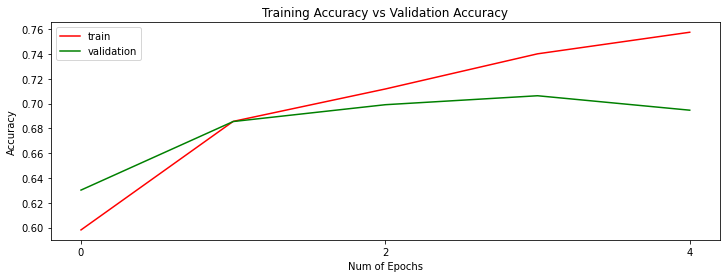

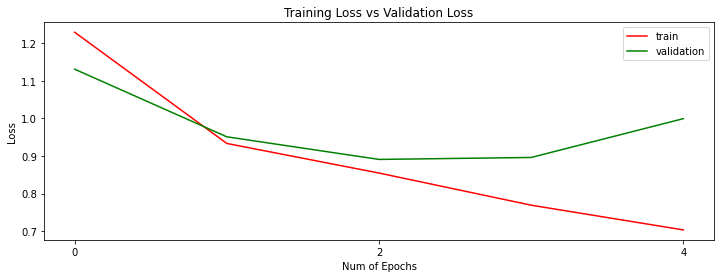

In [76]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

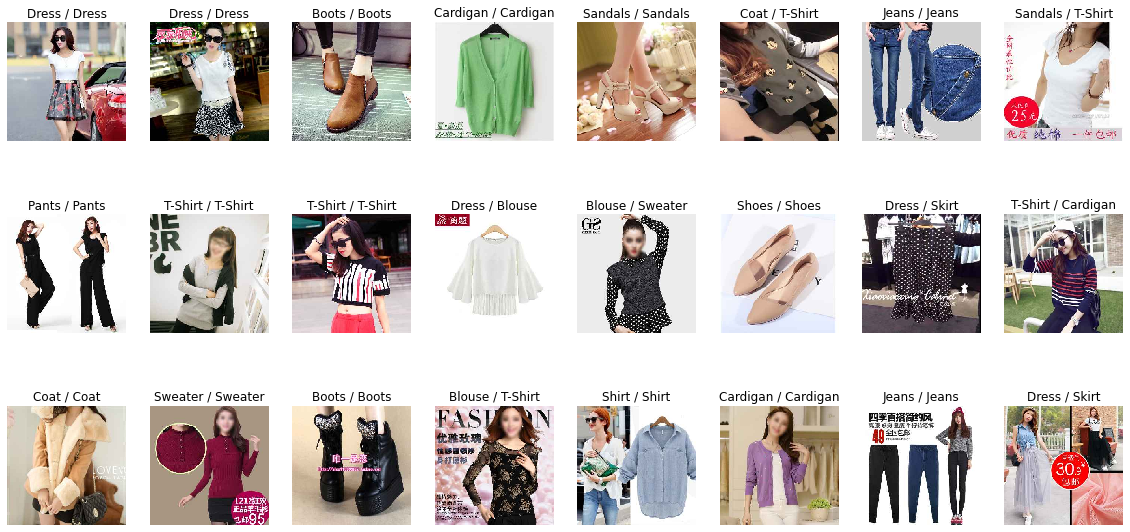

In [77]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()

## Model 8

In [5]:
model = load_model('densenet201_model_4.h5')

In [6]:
checkpoint = ModelCheckpoint(
    'densenet201_model_6.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [7]:
history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        verbose=1,
        shuffle=True)

Epoch 1/10
474/474 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7775
Epoch 00001: val_accuracy improved from -inf to 0.70162, saving model to densenet201_model_6.h5
474/474 [==============================] - 536s 1s/step - loss: 0.6482 - accuracy: 0.7775 - val_loss: 0.9410 - val_accuracy: 0.7016
Epoch 2/10
474/474 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7964
Epoch 00002: val_accuracy improved from 0.70162 to 0.70752, saving model to densenet201_model_6.h5
474/474 [==============================] - 238s 503ms/step - loss: 0.5901 - accuracy: 0.7964 - val_loss: 0.8928 - val_accuracy: 0.7075
Epoch 3/10
474/474 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.8147
Epoch 00003: val_accuracy improved from 0.70752 to 0.71490, saving model to densenet201_model_6.h5
474/474 [==============================] - 242s 511ms/step - loss: 0.5357 - accuracy: 0.8147 - val_loss: 0.9167 - val_accuracy: 0.7149
Epoch 4/10
474/4

In [8]:
model = load_model('densenet201_model_6.h5')
score = model.evaluate(test_generator)
score[1]

132/132 [==============================] - 90s 684ms/step - loss: 0.9261 - accuracy: 0.7073


0.7073083519935608

<Figure size 2160x720 with 0 Axes>

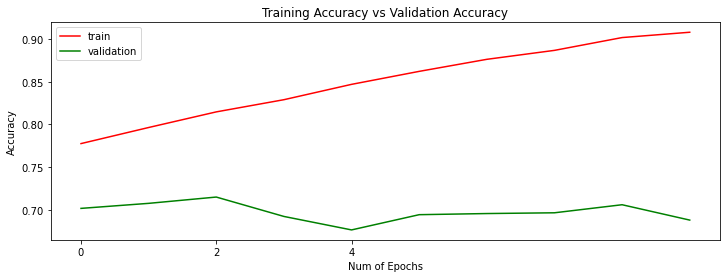

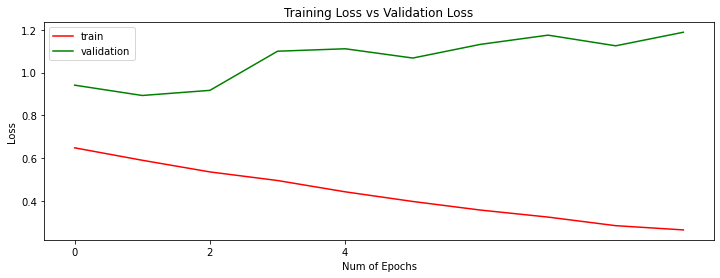

In [10]:
plt.figure(221, figsize=(30, 10))

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 6, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

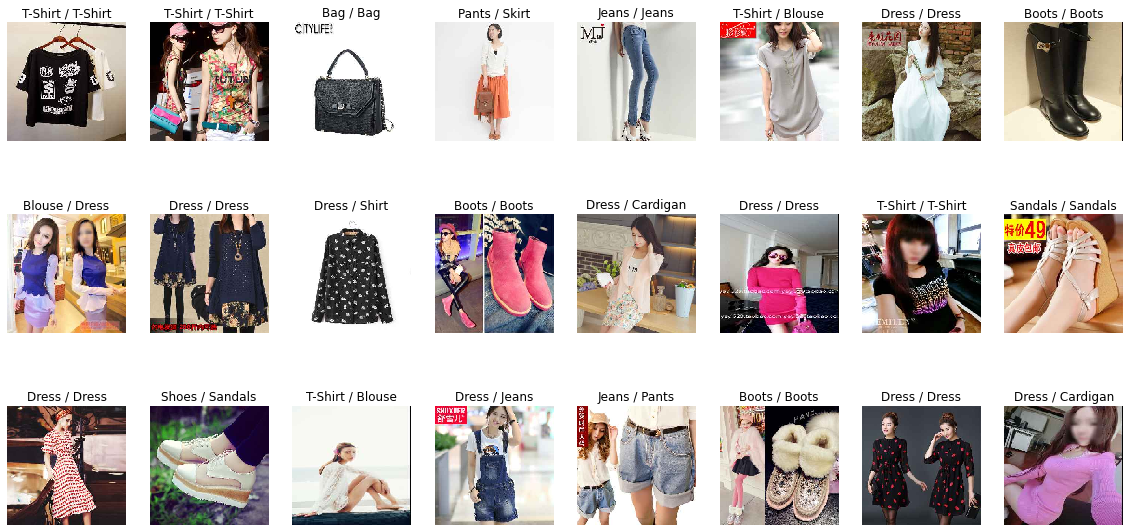

In [11]:
# Display the first few images
image_batch, label_batch = test_generator.next()

plt.figure(figsize=(20, 10))

for index in range (0, 24):
    image = image_batch[index]
    label = label_batch[index]
    plt.subplot(3, 8, index+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label==1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred = pred[0].argmax(axis=0)
    plt.title(class_names[pred] +  " / " + class_names[np.argmax(label)])
plt.show()